In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from keras.layers import Dense, Dropout
from keras.models import Sequential

In [3]:
os.chdir(r'N:\Heart Disease Classification')

In [4]:
df_heart = pd.read_csv('./heart.csv')
df_heart.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [5]:
df_heart.shape

(303, 14)

### Descriptive Statistics & Data Cleaning

In [9]:
df_heart = df_heart.rename(columns= {'cp':'chest_pain_type','trestbps':'resting_BP','chol':'serum_cholestoral','fbs':'fasting_blood_sugar','restecg':'resting_ECG',
                                     'thalach':'max_heart_rate','exang':'exercise_induced_angina',
                                     'ca':'major_vessels_count','thal':'thalium_stress'})
df_heart.columns

Index(['age', 'sex', 'chest_pain_type', 'resting_BP', 'serum_cholestoral',
       'fasting_blood_sugar', 'resting_ECG', 'max_heart_rate',
       'exercise_induced_angina', 'oldpeak', 'slope', 'major_vessels_count',
       'thalium_stress', 'target'],
      dtype='object')

In [6]:
df_heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
target      303 non-null int64
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [7]:
df_heart.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [11]:
categorical_cols = []
continous_cols = []

for column in df_heart.columns:
    if(len(df_heart[column].unique()) <= 10):
        categorical_cols.append(column)
    else:
        continous_cols.append(column)

In [12]:
categorical_cols

['sex',
 'chest_pain_type',
 'fasting_blood_sugar',
 'resting_ECG',
 'exercise_induced_angina',
 'slope',
 'major_vessels_count',
 'thalium_stress',
 'target']

In [13]:
continous_cols

['age', 'resting_BP', 'serum_cholestoral', 'max_heart_rate', 'oldpeak']

In [15]:
for cols in categorical_cols:
    if(cols != 'target'):
        df_heart[cols] = df_heart[cols].astype('object')

In [16]:
df_heart.dtypes

age                          int64
sex                         object
chest_pain_type             object
resting_BP                   int64
serum_cholestoral            int64
fasting_blood_sugar         object
resting_ECG                 object
max_heart_rate               int64
exercise_induced_angina     object
oldpeak                    float64
slope                       object
major_vessels_count         object
thalium_stress              object
target                       int64
dtype: object

In [17]:
df_heart.describe()

,age,resting_BP,serum_cholestoral,max_heart_rate,oldpeak,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,131.623762,246.264026,149.646865,1.039604,0.544554
std,9.082101,17.538143,51.830751,22.905161,1.161075,0.498835
min,29.000000,94.000000,126.000000,71.000000,0.000000,0.000000
25%,47.500000,120.000000,211.000000,133.500000,0.000000,0.000000
50%,55.000000,130.000000,240.000000,153.000000,0.800000,1.000000
75%,61.000000,140.000000,274.500000,166.000000,1.600000,1.000000
max,77.000000,200.000000,564.000000,202.000000,6.200000,1.000000


In [18]:
df_heart.describe(include='object')

,sex,chest_pain_type,fasting_blood_sugar,resting_ECG,exercise_induced_angina,slope,major_vessels_count,thalium_stress
count,303,303,303,303,303,303,303,303
unique,2,4,2,3,2,3,5,4
top,1,0,0,1,0,2,0,2
freq,207,143,258,152,204,142,175,166


### Target Distribution

In [19]:
df_heart.target.value_counts()

1    165
0    138
Name: target, dtype: int64

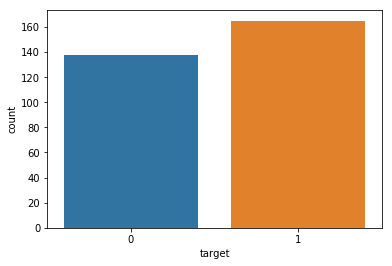

In [21]:
sns.countplot(df_heart['target'])

The data is not highly imbalanced, but I will try to balance it using SMOTE Oversampling.

### Exploratory Data Analysis

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000027070C8AA90>,
      dtype=object)

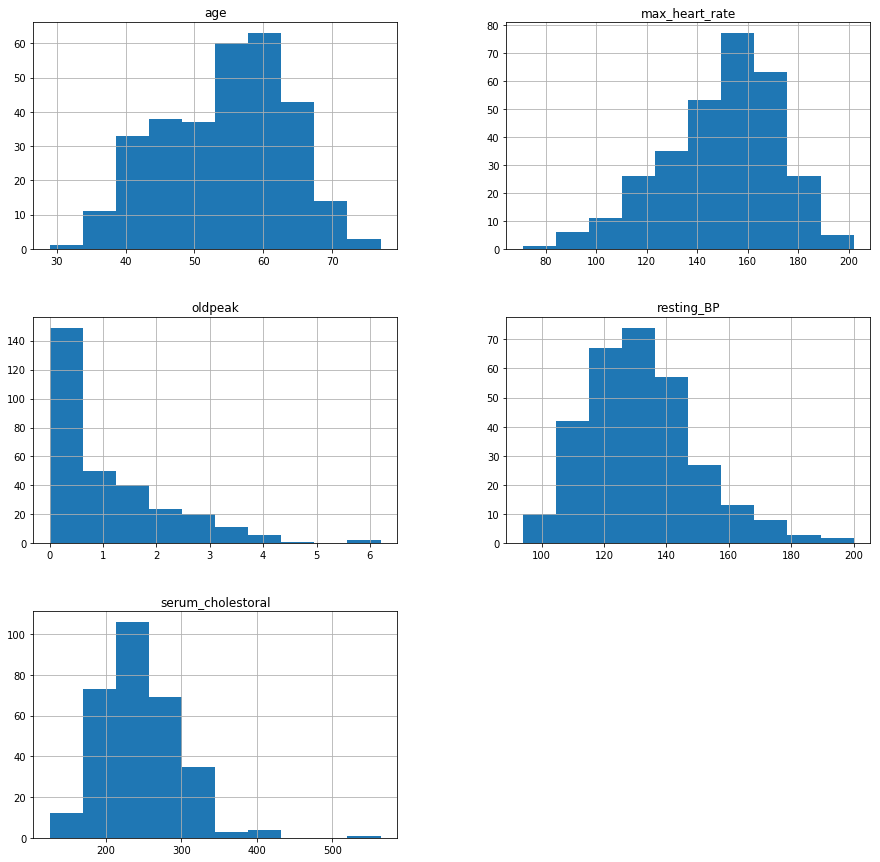

In [22]:
df_heart.hist(column=continous_cols, figsize=(15,15))

Old Peak seems to be highly skewed